# Classification of Japanese Characters

For this lab we will be using KMNIST, which is a variation on the MNIST challenge.  This dataset has 10 Japanese characters from the Kuzushiji alphabet as seen below where the clean/standardized version is on the far left and handwritten variations are along the rows.  

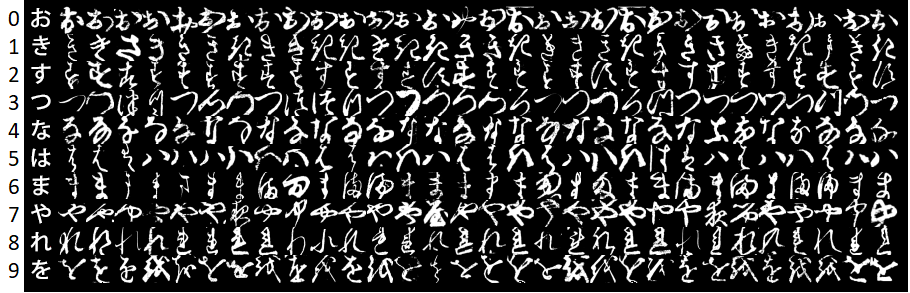

Kuzushiji is basically a cursive way to write Japanese characters, and more common characters actually have more variations than less common characters, which makes them harder to distinguish.  Translations made by experts have been established to take the handwritten characters and map them to modern, standardized versions.  For more, you can read about it here: https://www.tofugu.com/japanese/hentaigana-history-of-japanese-writing-system/

Wouldn't it be nice it this could be automated?  Let's start by loading some libraries...

Please note that this notebook must be run in a "Containerized" Jupyter Notebook on Rosie.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-11-07 10:41:12.652247: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 10:41:12.693687: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load and Visualize Data

The data are organized into four files:

* Training images
* Training labels
* Testing images
* Testing labels

These can be loaded with `np.load()`.  This will return a dict-like object with a single key: `arr_0`.  The objects need to be closed when done.

Images are stored as a 3D array: image, rows, columns.

In [2]:
with np.load("/data/cs2300/L8/kmnist-train-imgs.npz") as training_images_fl:
    print(list(training_images_fl.keys()))
    print(training_images_fl["arr_0"].shape)
    training_images = training_images_fl["arr_0"]
    
with np.load("/data/cs2300/L8/kmnist-test-imgs.npz") as testing_images_fl:
    print(list(testing_images_fl.keys()))
    print(testing_images_fl["arr_0"].shape)
    testing_images = testing_images_fl["arr_0"]
    
with np.load("/data/cs2300/L8/kmnist-train-labels.npz") as training_labels_fl:
    print(list(training_labels_fl.keys()))
    print(training_labels_fl["arr_0"].shape)
    training_labels = training_labels_fl["arr_0"]
    
with np.load("/data/cs2300/L8/kmnist-test-labels.npz") as testing_labels_fl:
    print(list(testing_labels_fl.keys()))
    print(testing_labels_fl["arr_0"].shape)
    testing_labels = testing_labels_fl["arr_0"]

['arr_0']
(60000, 28, 28)
['arr_0']
(10000, 28, 28)
['arr_0']
(60000,)
['arr_0']
(10000,)


Let's take a look at some of the characters.  

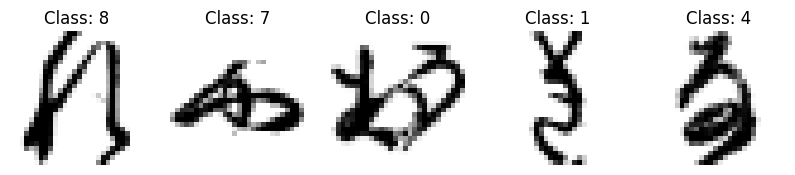

In [3]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))
for ax, image, label in zip(axes, training_images, training_labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Class: %i' % label)

## Set up Data for Deep Learning Models

In the following cell, we reshape and prepare the data for training.  The data needs to be in 4D tensors of shape (N,28,28,1) where N is the number of images.  Each image is 28x28 pixels.  Since they are greyscale, the images only have a single channel. 

The tensors represent the 256 possible gray colors using integer values (e.g., 0, 1, 2, …, 255).  You need to convert the tensors to 32-bit floats and divide by 255 to scale the pixels to the range of [0, 1].  You should add the lines of code to do this in the area marked TODO below.

In [41]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

x_train = training_images
x_test = testing_images

# Convert class vectors to binary class matrices
y_train = training_labels
y_test = testing_labels

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train / 255
x_test = x_test / 255

# create the data generator to feed the training with augmentations
datagen = ImageDataGenerator(
            rotation_range= 5,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # randomly zoom image 
            width_shift_range=0.01,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.01)  # randomly shift images vertically (fraction of total height
datagen.fit(x_train)

In the following cell, print out the number of training and test samples using x_train and x_test.  Store these values in variables named train_samples and test_samples (respectively).  

In [42]:
print(x_train.shape[0])
print(x_test.shape[0])

train_samples = x_train.shape[0]
test_samples = x_test.shape[0]

60000
10000


## Create the first model

Next we will create a fully connected feed forward neural network (aka. Dense Neural Network (DNN)) model.  You need to add a line of code below to calculate the number of steps per epoch based on the number of training samples and batch size.  

In [43]:
dnn_epochs = 10
dnn_batch_size = 64

steps_per_epoch = train_samples / dnn_batch_size

dnn_model = Sequential()
dnn_model.add(Flatten())
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dense(num_classes, activation='softmax'))

dnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


## DNN Training

You should then run the next cell with the current hyperparameters, and then experiment with different epoch numbers, batch sizes, and data augmentation (rotation, zoom) to determine what configuration gives a "good" balance of accuracy and performance.  If you are feeling ambitious, you could experiment with the number of hidden dense layers and optimization functions (https://keras.io/api/optimizers/).  Record all your experiments in a markdown table in the DNN Results table below.  You should run at least 5 different experiments.  

Hints:
- You can determine the model size (total number of parameters) using the .summary() method for each model you create. 
- You can measure the test accuracy using the code below.

After running all your experiments for the DNN, you should create a plot that shows how they trade off performance (training time) vs. test accuracy.

Make a few statements on what you observed about the relationships between the data you captured in the table.  There should be notable correlations.    

In [44]:
%%time

history = dnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  steps_per_epoch = steps_per_epoch,
                                  epochs=dnn_epochs,
                                    validation_data=(x_test, y_test))

dnn_model.summary()

Epoch 1/10


2023-11-07 12:36:01.366181: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


937/937 [==============================] - 13s 12ms/step - loss: 0.5301 - accuracy: 0.8345 - val_loss: 0.5988 - val_accuracy: 0.8150
Epoch 2/10
937/937 [==============================] - 12s 12ms/step - loss: 0.2900 - accuracy: 0.9104 - val_loss: 0.5360 - val_accuracy: 0.8376
Epoch 3/10
937/937 [==============================] - 12s 13ms/step - loss: 0.2289 - accuracy: 0.9273 - val_loss: 0.4443 - val_accuracy: 0.8691
Epoch 4/10
937/937 [==============================] - 12s 12ms/step - loss: 0.1944 - accuracy: 0.9397 - val_loss: 0.4162 - val_accuracy: 0.8777
Epoch 5/10
937/937 [==============================] - 12s 12ms/step - loss: 0.1784 - accuracy: 0.9442 - val_loss: 0.4046 - val_accuracy: 0.8842
Epoch 6/10
937/937 [==============================] - 12s 12ms/step - loss: 0.1605 - accuracy: 0.9500 - val_loss: 0.3987 - val_accuracy: 0.8866
Epoch 7/10
937/937 [==============================] - 12s 13ms/step - loss: 0.1465 - accuracy: 0.9556 - val_loss: 0.3957 - val_accuracy: 0.8915
Epo

## DNN Results

| Model Name  | Optimizer | # Params | # Epochs | Batch Size | Rotation | Zoom | Train Acc | Test Acc | Tr. Time w/GPU | Tr. 
| ----------- | --------- | -------- | -------- | ---------- | -------- | ---- |---------- | -------- | -------------- | ----------------- |
| Default     | SGD       | 118,282  | 5        | 64         | 0        | 0.1  | 89.37%    | 79.07%   | 1min 24s       | 7.49s              |
| Default     | SGD       | 118,282  | 20       | 64         | 15       | 0.2  | 89.77%    | 83.83%   | 5min 53s       | 30.70s            |
| Default     | ADAM      | 118,282  | 15       | 32         | 5        | 0    | 98.59%    | 91.01%   | 8min 9s        | 43.5s              |
| Default     | ADAM      | 118,282  | 10       | 64         | 5        | 0.1  | 96.42%    | 90.81%   | 2min 54s       | 15.4s              |
| Default     | ADAM      | 134,794  | 10       | 64         | 5        | 0.1  | 96.19%    | 90.18%   | 2min 58s       | 14.6s              |

in the table a couble relations can be seen. Higher rotation and zoom generally decrease accuracy however this also increases how general the model is. Addiitonally adding more parameter while keeping everything eles ethe same did not afect accuracy positively and keep it almost the same. Reducing batch size caused the model to learn significantly faster, this additonaly cause it to be the model which trained for the longest aswell making it the one with highest acuracy and longer train time.
Adam optimizer had much better accuracy than SGD.


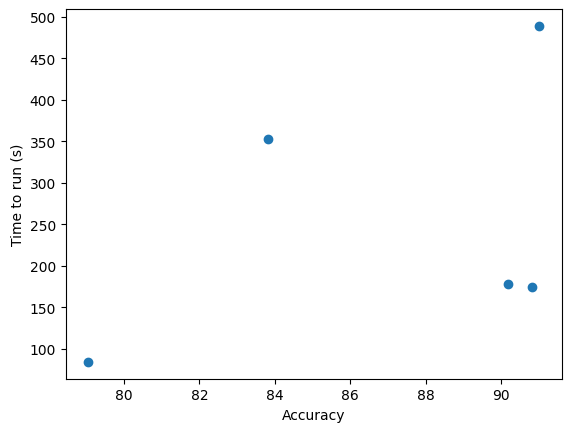

In [48]:
x = np.array([79.05,83.83,91.01,90.81,90.18])
y = np.array([84,353,489,174,178])

plt.scatter(x, y)
plt.ylabel('Time to run (s)')
plt.xlabel('Accuracy')
plt.show()

This graph did not show a strong correlation with training time and acuracy however each individual entty was not kept under constant conditions so this was not a fair test.

## Accuracy
In the next cell, we calculate the accuracy of the model against an unseen set of data "test".  Remember, this data was not used in training, so it is a measure of the real-world generalization capability of the model.    

In [49]:
predicted_probabilities = dnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)
acc = 100. * accuracy_score(y_test, predicted_classes)
print("Accuracy: {:.2f}%".format(acc))

313/313 [==============================] - 0s 985us/step
Accuracy: 90.18%


## Confusion Matrix
In the next cell we create a confusion matrix using the "test" data using the most recently fit model.  On the y-axis is the true label and on the x-axis is the predicted label from the model.  Larger counts on the diagonal indicates more correctly classified characters.  

In the markdown cell below, please identify which configuration of hyperparameters and data augmentation resulted in the best looking confusion matrix and whether it was the same as the configuration you identified earlier.  If they are different, hypothesize why.  

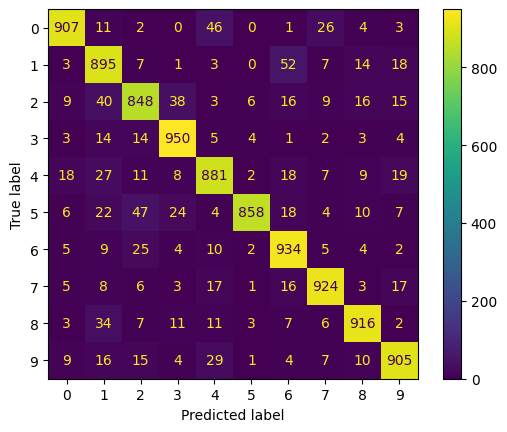

In [50]:
cm = confusion_matrix(y_test, predicted_classes)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

## Reflection on Confusion Matrix
The graph shows a pretty strong accuracy. Additionaly it did not show any strong bias to any specific number suggesting the dataset most likely does not contain more of one data than an other.

# Create and Evaluate CNN
Next, we create an Convolutional Neural Network (CNN) Model.  Similar to the DNN model, you should calculate the steps_per_epoch below.  

As with the DNN model above, adjust the hyperparameters and data augmentation to try to achieve the best possible accuracy.  You can also try uncommenting the lines below to add some layers to the model to see if that has an effect on training time or accuracy.  Capture all your experiments in a table below.  

In [70]:
cnn_epochs = 10
cnn_batch_size = 32

steps_per_epoch = train_samples / cnn_batch_size

cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [71]:
%%time
history_cnn = cnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  epochs=cnn_epochs, steps_per_epoch=steps_per_epoch,
                                    validation_data=(x_test, y_test))

Epoch 1/10


2023-11-07 15:16:08.249786: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-07 15:16:09.118326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 [==============================] - 23s 11ms/step - loss: 0.3072 - accuracy: 0.9057 - val_loss: 0.2932 - val_accuracy: 0.9192
Epoch 2/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1129 - accuracy: 0.9674 - val_loss: 0.2065 - val_accuracy: 0.9435
Epoch 3/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0776 - accuracy: 0.9766 - val_loss: 0.2017 - val_accuracy: 0.9450
Epoch 4/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0587 - accuracy: 0.9828 - val_loss: 0.2063 - val_accuracy: 0.9532
Epoch 5/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0463 - accuracy: 0.9865 - val_loss: 0.1869 - val_accuracy: 0.9589
Epoch 6/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0373 - accuracy: 0.9887 - val_loss: 0.1847 - val_accuracy: 0.9602
Epoch 7/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0326 - accuracy: 0.9900 - val_loss: 0.2246 - val_accura

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_18 (Flatten)        (None, 9216)              0         
                                                                 
 dense_51 (Dense)            (None, 128)               1179776   
                                                     

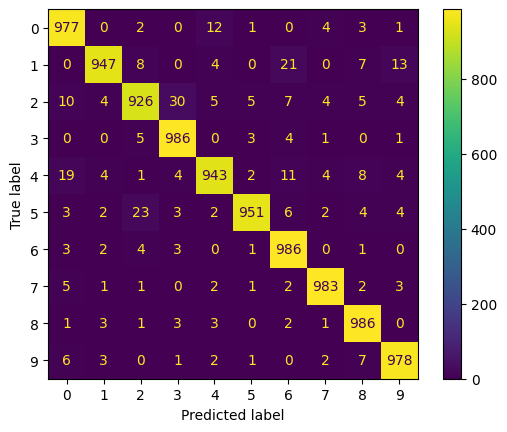

Accuracy: 96.63%


In [72]:
cnn_model.summary()
predicted_probabilities = cnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

acc = 100. * accuracy_score(y_test, predicted_classes)
cm = confusion_matrix(y_test, predicted_classes)

cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

print("Accuracy: {:.2f}%".format(acc))

## CNN Results


| Model Name  | Optimizer | # Params  | # Epochs | Batch Size | Rotation | Zoom | Train Acc | Test Acc | Tr. Time w/GPU | Tr. 
| ----------- | --------- | --------  | -------- | ---------- | -------- | ---- |---------- | -------- | -------------- | ----------------- |
| CNN         | SGD       | 1,199,882 | 5        | 64         | 0        | 0.1  | 92.09%    | 85.83%   | 1min 27s       | 7.27s              |
| CNN         | ADAM      | 1,199,882 | 10       | 64         | 0        | 0.1  | 99.34%    | 95.09%   | 3min 4s        | 13.7s              |
| CNN+dropout | ADAM      | 1,216,394 | 10       | 64         | 0        | 0.1  | 98.94%    | 95.84%   | 3min 5s        | 14 s                |
| CNN+2dropout| ADAM      | 1,216,394 | 10       | 32         | 0        | 0.1  | 99.30%    | 96.63%   | 6min 7s        | 27.1 s              |



Identify the "best" confusion matrix for your CNN models

## In this cell, answer the following questions 

1. Which model (CNN or DNN) achieved the best test accuracy, why?

CNN (~97%) chieved a much better accuracy than the DNN (95%). This is because the CNNs greater complexity and capability to extract features through the spacial awarness of pixels. DNNS compared pixel values directly however CNNS have the ability to look at how pixel values relate to each other spacially allowing for more complex patterns to be recognised.
Hint: it is possible to achieve better than 95% accuracy on the test set! I DID!

2. Which model trained faster?  On what hardware (GPU/CPU only)?  Why might this be happening?
The DNN model trained faster, This was due to the fact that it had more trainable parameters to tweak than the DNN. The CNN did not have less fully connected layers than the DNN so it was not surprising it took less time to run.

3. Which model was larger (had the most parameters)?  How many parameters did each model have?  Is the number of parameters related to the time it takes to train the model?  
The CNN had a bigger model as it had more parameters thant the DNN. The best DNN model had 134,794. The best CNN model had 1,216,394. The CNN took longer to train so yes, the number of parameters is porpotional to the time it takes to train.  

4. Based on your confusion matrices, which class was the most difficult to be accurate?  Was it consistently difficult among different models?  How can you use the results from the confusion matrix to inform how you would test the mobile app for accuracy?
The number 2 seemed to be the hardest to detect however this was not by a huge factor. The number 2 did not have a level of complexity which made it significantly harder to detect. The number 2 was consitently the worse result in all models. When testing the app testing the numbers which performed worse in the matrix more would be beneficial to check how effective the model is which these examples.

5. What affect did data augmentation have on the CNN and DNN models?  
Data augmentation had a small positive effect on the CNN as it had more data to generelise and improve upon in the testing accuracy. However the DNN did not have a positive effect, this is due to the change of consitency as data that was created wasnt consistent in the way it was placed.

6. What did you notice when you deployed the models on the Android device?  Were the accuracy differences between the models noticeable?  
Yes, Even though the accuracy of the model was quite high, when deployed I struggled getting the app to give me the right awnsers for the numbers I was trying to write. This may be due to the fact that I have no clue how to write japanese digits well and the model is incapable of seeing past my handwritting mistakes.


## Converting the model to TFLite for exporting to Android/iOS

In [73]:
# TODO make sure you are exporting the right model here!
converter = tf.lite.TFLiteConverter.from_keras_model(dnn_model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

INFO:tensorflow:Assets written to: /tmp/tmpltf3l5yb/assets
Float model size = 529KBs.


2023-11-07 16:10:35.613938: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-07 16:10:35.613970: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-07 16:10:35.617674: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpltf3l5yb
2023-11-07 16:10:35.621383: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-11-07 16:10:35.621421: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpltf3l5yb
2023-11-07 16:10:35.629694: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-11-07 16:10:35.630674: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-07 16:10:35.674570: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpltf3l5yb
2023-11

Since this model will be on a mobile device, we want it to small and fast.  **Quantization** is an approach used to shrink ML models. In the following code, we use 8-bit numbers to approximate our 32-bit weights, which shrinks the model size by a factor of 4.

In [74]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

INFO:tensorflow:Assets written to: /tmp/tmp1zhnzjay/assets


INFO:tensorflow:Assets written to: /tmp/tmp1zhnzjay/assets


Quantized model size = 135KBs,
which is about 25% of the float model size.


2023-11-07 16:10:49.516616: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-07 16:10:49.516646: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-07 16:10:49.516798: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1zhnzjay
2023-11-07 16:10:49.517827: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-11-07 16:10:49.517844: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1zhnzjay
2023-11-07 16:10:49.521332: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-07 16:10:49.560580: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1zhnzjay
2023-11-07 16:10:49.570913: I tensorflow/cc/saved_model/loader.cc:334] SavedModel load for tags { serve }; Status: success: OK. Took 54116 m

Next, we download the TFLite model to be used in the mobile device!

In [75]:
# Save the quantized model to file to the Downloads directory
f = open('kmnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

print('`kmnist.tflite` has been downloaded')

`kmnist.tflite` has been downloaded


This notebook was originally created by RJ Nowling and modified by Derek Riley